# Predict

In [1]:
import random
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, BatchSampler
from torchinfo import summary
from tqdm import tqdm

from torchscale.architecture.config import EncoderConfig
from torchscale.architecture.encoder import Encoder

/home/xt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## §0 `utils.py` def `seed_everything`

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## §1 import `src.dataset_beit3`

### §1.1 def `prepare_sensors`

In [3]:
def prepare_sensors():
    sensors = pd.read_csv("data/sensor_geometry.csv").astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 0  # or 1, Quantum Efficiency

    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i# classify sensors with string

        # High Quantum Efficiency in the lower 50 DOMs - https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            sensors.loc[start_core:end_core, "qe"] = 1  # 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500

    return sensors

### §1.2 class `IceCubeDatatest`

In [4]:
class IceCubeDatatest(Dataset):
    def __init__(self, dim_base=128, batch_id=1):
        # dim_base for nomalize
        self.dim_base = dim_base
        
        # 1. load `batch_1.parquet` and concat the same event_id together
        batch_1 = pd.read_parquet(os.path.join("data/train", "batch_"+str(batch_id)+".parquet"))# data/train/batch_1.parquet
        batch_1 = batch_1.groupby('event_id').agg({
            'sensor_id': list,
            'time': list,
            'charge': list,
            'auxiliary': list
        })
        batch_1.reset_index(drop=True, inplace=True)# event_id -> index
        self.batch_1 = batch_1
        
        # 2. geometry
        sensors = prepare_sensors()
        self.geometry = torch.from_numpy(sensors[["x", "y", "z"]].values.astype(np.float32))
        self.qe = sensors["qe"].values
        
        # 3. load `train_meta.parquet` to get target: azimuth and zenith
        train_meta = pd.read_parquet('data/train_meta.parquet')
        batch_1_meta = train_meta[train_meta['batch_id'] == batch_id]
        batch_1_meta.reset_index(drop=True, inplace=True)# event_id -> index
        self.batch_1_meta = batch_1_meta
        
        assert len(self.batch_1)==len(self.batch_1_meta), "batch_1 and batch_1_meta length doesn't match"

    def __len__(self):
        return len(self.batch_1)
    
    def __getitem__(self, index):
        # 1. for each event in `batch_1.parquet`
        batch_1_event = self.batch_1.loc[index]
        sensor_id = np.array(batch_1_event["sensor_id"])
        time = np.array(batch_1_event["time"])
        time = (time - 1e4) / 3e4
        charge = np.array(batch_1_event["charge"])
        charge = np.log10(charge) / 3.0
        auxiliary = np.array(batch_1_event["auxiliary"])

        # normalize so that the length of each event is 128
        dim_base = len(sensor_id)
        # the output of this method
        dim_base_0 = dim_base
        if dim_base < self.dim_base:
            # assignment
            sensor_id = np.pad(sensor_id, (0, max(0, self.dim_base - dim_base)))
            time = np.pad(time, (0, max(0, self.dim_base - dim_base)))
            charge = np.pad(charge, (0, max(0, self.dim_base - dim_base)))
            auxiliary = np.pad(auxiliary, (0, max(0, self.dim_base - dim_base)))
        else:
            # generate a randomly arranged index array ids
            ids = torch.randperm(dim_base).numpy()
            # negtive index
            auxiliary_n = np.where(~auxiliary)[0]
            # positive index
            auxiliary_p = np.where(auxiliary)[0]
            # choose as many as ids in the negtive index
            ids_n = ids[auxiliary_n][: min(self.dim_base, len(auxiliary_n))]
            # the rest is positive index
            ids_p = ids[auxiliary_p][: min(self.dim_base - len(ids_n), len(auxiliary_p))]
            # concat into a new index
            ids = np.concatenate([ids_n, ids_p])
            # sort the index (from small to big)
            ids.sort()
            # assignment
            sensor_id = sensor_id[ids]
            time = time[ids]
            charge = charge[ids]
            auxiliary = auxiliary[ids]
            dim_base = len(ids)

        # 2. geometry
        sensor_id = torch.from_numpy(sensor_id).long()
        pos = self.geometry[sensor_id]
        pos[dim_base:] = 0
        qe = self.qe[sensor_id]
        qe[dim_base:] = 0
        
        # 3. target
        azimuth = self.batch_1_meta.loc[index].azimuth
        zenith = self.batch_1_meta.loc[index].zenith
        target = np.array([azimuth, zenith]).astype(np.float32)
        target = torch.from_numpy(target)
        
        # 4. mask
        mask = torch.zeros(self.dim_base, dtype=torch.bool)
        mask[:dim_base] = True

        return {
            "time": torch.from_numpy(time).float(),
            "charge": torch.from_numpy(charge).float(),
            "auxiliary": torch.from_numpy(auxiliary).long(),
            "pos": pos,
            "mask": mask,
            "qe": qe,
            "dim_base_0": dim_base_0
        }#, {"target": target}

## §2 `model.py`

### §2.1 class `SinusoidalPosEmb`

In [5]:
class SinusoidalPosEmb(nn.Module):# Sinusoidal Position Embedding
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[..., None] * emb[None, ...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

### §2.2 class `IceCubeEmbedding`

- `dim_base` is the dimension of normalize, see `IceCubeDataset`, `dim` is the dimension of embedding

In [6]:
class IceCubeEmbedding(nn.Module):
    def __init__(self, dim=384, dim_base=128):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.aux_emb = nn.Embedding(2, dim_base // 2)
        self.emb2 = SinusoidalPosEmb(dim=dim_base // 2)
        self.proj = nn.Sequential(
            nn.Linear(6 * dim_base, 6 * dim_base),
            nn.LayerNorm(6 * dim_base),
            nn.GELU(),
            nn.Linear(6 * dim_base, dim),
        )

    def forward(self, x, Lmax=None):
        pos = x["pos"] if Lmax is None else x["pos"][:, :Lmax]
        charge = x["charge"] if Lmax is None else x["charge"][:, :Lmax]
        time = x["time"] if Lmax is None else x["time"][:, :Lmax]
        auxiliary = x["auxiliary"] if Lmax is None else x["auxiliary"][:, :Lmax]
        length = torch.log10(x["dim_base_0"].to(dtype=pos.dtype))

        x = torch.cat(
            [
                #self.cls_token,
                self.emb(4096 * pos).flatten(-2),
                self.emb(1024 * charge),
                self.emb(4096 * time),
                self.aux_emb(auxiliary),
                self.emb2(length).unsqueeze(1).expand(-1, pos.shape[1], -1)
            ],
            -1,
        )
        x = self.proj(x)
        return x

### §2.3 class `IceCubeModel`

[microsoft/torchscale (github.com)](https://github.com/microsoft/torchscale/tree/main)

1. Use `Encoder` from `torchscale`
    
    ```python
    from torchscale.architecture.config import EncoderConfig
    from torchscale.architecture.encoder import Encoder

    encoder_config = EncoderConfig(encoder_embed_dim = 384)
    encoder = Encoder(encoder_config)

    # to test encoder:
    # https://github.com/microsoft/torchscale/blob/main/tests/test_encoder.py
    dummy = torch.rand(32, 129, 384)
    dummy = encoder(src_tokens=None, token_embeddings=dummy)
    dummy = dummy['encoder_out']
    print(dummy.shape)
    ```
    
    The output is:
    
    ```python
    torch.Size([32, 129, 384])
    ```

2. First take the slices then use `self.proj_out` to get xyz. 32 is batch_size
    
    ```python
    x = torch.randn(32, 129, 384)
    print(x[:, 0, :].shape)
    proj_out = nn.Linear(384, 3)
    x = proj_out(x[:, 0, :])
    print(x.shape)
    ```
    
    The output is:
    
    ```Shell
    torch.Size([32, 384])
    torch.Size([32, 3])
    ```

In [7]:
class IceCubeModel(nn.Module):
    def __init__(
        self,
        dim=384,
        dim_base=128
    ):
        super().__init__()
        self.icecube_embedding = IceCubeEmbedding(dim, dim_base)
        encoder_config_1 = EncoderConfig(
            encoder_attention_heads=6,
            encoder_embed_dim=dim,
            encoder_ffn_embed_dim=1536,# Feed Forward Network
            encoder_layers=4,
            # relative position bias, see [1910.10683]
            rel_pos_buckets=32,
            max_rel_pos=dim_base
        )
        self.encoder_1 = Encoder(encoder_config_1)
        self.cls_token = nn.Linear(dim, 1, bias=False)
        encoder_config_2 = EncoderConfig(
            encoder_attention_heads=12,
            encoder_embed_dim=dim,
            encoder_ffn_embed_dim=1536,# Feed Forward Network
            encoder_layers=12
        )
        self.encoder_2 = Encoder(encoder_config_2)
        self.proj_out = nn.Linear(dim, 3)

    def forward(self, x0):
        # mask
        mask = x0["mask"]
        Lmax = mask.sum(-1).max()
        # cls token
        batch_size, _ = mask.shape
        cls_token = self.cls_token.weight.unsqueeze(0).expand(batch_size, -1, -1)
        # x
        x = self.icecube_embedding(x0, Lmax)
        # encoder 1
        x = self.encoder_1(src_tokens=None, token_embeddings=x)
        x = x['encoder_out']
        # concat cls token
        x = torch.cat([cls_token, x], 1)
        # encoder 2
        x = self.encoder_2(src_tokens=None, token_embeddings=x)
        x = x['encoder_out']
        x = self.proj_out(x[:, 0, :])# get cls token, then xyz
        return x

In [8]:
summary(IceCubeModel())

Layer (type:depth-idx)                        Param #
IceCubeModel                                  --
├─IceCubeEmbedding: 1-1                       --
│    └─SinusoidalPosEmb: 2-1                  --
│    └─Embedding: 2-2                         128
│    └─SinusoidalPosEmb: 2-3                  --
│    └─Sequential: 2-4                        --
│    │    └─Linear: 3-1                       590,592
│    │    └─LayerNorm: 3-2                    1,536
│    │    └─GELU: 3-3                         --
│    │    └─Linear: 3-4                       295,296
├─Encoder: 1-2                                --
│    └─Dropout: 2-5                           --
│    └─ModuleList: 2-6                        --
│    │    └─EncoderLayer: 3-5                 1,778,304
│    │    └─EncoderLayer: 3-6                 1,778,304
│    │    └─EncoderLayer: 3-7                 1,778,304
│    │    └─EncoderLayer: 3-8                 1,778,304
│    └─LayerNorm: 2-7                         768
│    └─RelativePositi

## §3 `loss.py`

### §3.1 def `mse_loss`

Shape of input:
- `pred`: shape is [batch_size, 3], "3" is xyz.
- `y["target"]`: shape is [batch_size, 2], "2" is azimuth and zenith.

In [9]:
def mse_loss(pred, y):
    pred = pred.float()
    l = torch.norm(pred.float(), dim=-1).unsqueeze(-1)
    pred = pred.float()
    
    sa2 = torch.sin(y["target"][:, 0])
    ca2 = torch.cos(y["target"][:, 0])
    sz2 = torch.sin(y["target"][:, 1])
    cz2 = torch.cos(y["target"][:, 1])
    target = torch.stack([sa2 * sz2, ca2 * sz2, cz2], -1)
    
    loss = nn.MSELoss()(pred, target)
    return loss

### §3.2 def `competition_metric`

Shape of input:
- `pred`: shape is [batch_size, 3], "3" is xyz.
- `y["target"]`: shape is [batch_size, 2], "2" is azimuth and zenith.

Official metric of the kaggle competition：$$\Psi = \arccos (\sin{\vartheta_\text{true}}\sin{\vartheta_\text{reco}}(\cos{{\varphi_\text{ture}}}\cos{{\varphi_\text{reco}}}+\sin{{\varphi_\text{ture}}}\sin{{\varphi_\text{reco}}})+\cos{\vartheta_\text{true}}\cos{\vartheta_\text{reco}})$$

In [10]:
def competition_metric(pred, y):
    pred = F.normalize(pred.double(), dim=-1)

    sa2 = torch.sin(y["target"][:, 0])#sin(azimuth)
    ca2 = torch.cos(y["target"][:, 0])
    sz2 = torch.sin(y["target"][:, 1])#sin(zenith)
    cz2 = torch.cos(y["target"][:, 1])

    scalar_prod = (
        pred[:, 0] * sa2 * sz2 + pred[:, 1] * ca2 * sz2 + pred[:, 2] * cz2
    ).clip(-1 + 1e-8, 1 - 1e-8)
    return torch.acos(scalar_prod).abs().mean(-1).float()

## §4 `predict.py`

In [11]:
batch_id = 1
seed_everything(42)

### §4.1 Angular Error Distribution

In [12]:
# load pretrained model
icecube_model = IceCubeModel()
weight = torch.load('BEiT3_29M_MSE_rel128_FULL/models/BEiT3_29M_MSE_rel128_FULL_0.pth') 
icecube_model.load_state_dict(weight)
icecube_model.eval()
icecube_model.to("cuda")
# load dataset
dataset = IceCubeDatatest(batch_id = batch_id)
data_size = len(dataset)
indices = list(range(data_size))
batch_sampler = BatchSampler(
    torch.utils.data.SequentialSampler(indices),
    batch_size=32,# parallel processing
    drop_last=False
)
dataloader = DataLoader(
    dataset,
    num_workers=1,
    batch_sampler=batch_sampler
)

In [13]:
def dict_to(x, device):
    return {k: x[k].to(device) for k in x}

In [14]:
preds = torch.tensor([]).to("cuda")
for x in tqdm(dataloader):
    with torch.no_grad():
        x = dict_to(x, "cuda")
        preds = torch.cat((preds, icecube_model(x)), dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6250/6250 [03:48<00:00, 27.39it/s]


In [15]:
# print(preds)
# print(preds.shape)

In [16]:
train_meta = pd.read_parquet('data/train_meta.parquet')
batch_1_meta = train_meta[train_meta['batch_id'] == batch_id]
batch_1_meta.reset_index(drop=True, inplace=True)# event_id -> index

In [17]:
competition_metrics = torch.tensor([]).to("cuda")
for i in range(data_size):
    # get azimuth and zenith
    azimuth = batch_1_meta.loc[i].azimuth
    zenith = batch_1_meta.loc[i].zenith
    target = np.array([azimuth, zenith]).astype(np.float32)
    target = torch.from_numpy(target)
    target = target.unsqueeze(0).to("cuda")
    target = {"target": target}
    competition_metric_i = competition_metric(preds[i].unsqueeze(0), target)
    competition_metric_i = torch.tensor([competition_metric_i]).to("cuda")
    competition_metrics = torch.cat((competition_metrics, competition_metric_i),dim=0)

In [18]:
#print(competition_metrics)
#print(competition_metrics.shape)

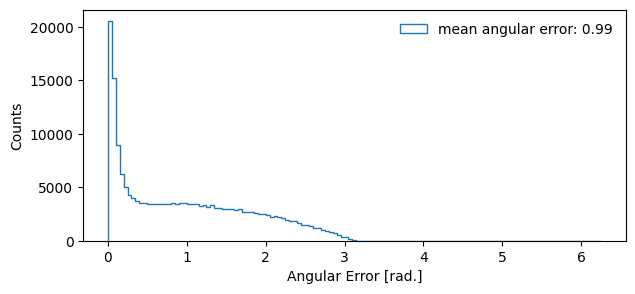

In [19]:
# since kappa is not predicted in our model, a sigma histogram can not be plotted

fig = plt.figure(figsize = (7,3))
plt.hist(competition_metrics.to("cpu").numpy(), 
         bins = np.arange(0,np.pi*2, 0.05), 
         histtype = 'step', 
         label = f'mean angular error: {competition_metrics.to("cpu").numpy().mean():,.2f}')
plt.xlabel('Angular Error [rad.]')
plt.ylabel('Counts')
#plt.title(f'Angular Error Distribution (Batch {batch_id})', size = 15)
plt.legend(frameon = False)

### §4.2 Distribution of the Angular Error

In [20]:
def xyz_to_angle(xyz):
    z_normed = xyz[:, 2] / torch.norm(xyz ,dim=1)
    x_normed = xyz[:, 0] / torch.norm(xyz[:, :2] ,dim=1)
    azimuth = ( torch.arccos(x_normed) * torch.sign(xyz[:, 1]) ) % (np.pi * 2)
    zenith = torch.arccos(z_normed)
    angle = torch.stack((azimuth, zenith), dim=1)
    return angle

preds_angle = xyz_to_angle(preds)

In [21]:
azimuth = torch.tensor(batch_1_meta["azimuth"])
azimuth = azimuth.unsqueeze(0)
zenith = torch.tensor(batch_1_meta["zenith"])
zenith = zenith.unsqueeze(0)
target_angle = torch.cat((azimuth,zenith),dim=0)
target_angle = torch.transpose(target_angle, 0, 1)

In [22]:
difference = preds_angle.to("cpu") - target_angle.to("cpu")
difference = difference.numpy()
x = difference[:, 0]
y = difference[:, 1]

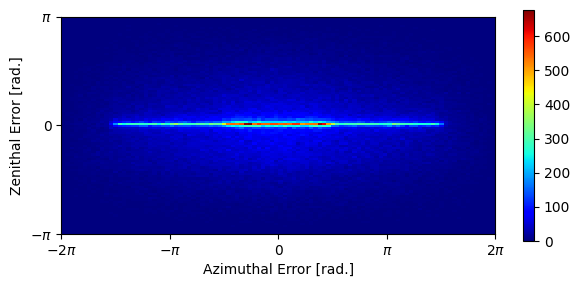

In [23]:
H, xedges, yedges = np.histogram2d(x, y, bins=(100,100))
H = H.T
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-np.pi, np.pi)
plt.xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi],
           [r"$-2 \pi$", r"$- \pi$", "0", r"$\pi$", r"$2 \pi$"])
plt.yticks([-np.pi, 0, np.pi],
           [r"$- \pi$", "0", r"$\pi$"])
plt.xlabel("Azimuthal Error [rad.]")
plt.ylabel("Zenithal Error [rad.]")
#plt.title(f'Distribution of the Angular Error (Batch {batch_id})')
plt.imshow(H, interpolation='nearest', origin='lower',
           extent=[-2*np.pi, 2*np.pi, -np.pi, np.pi],
           cmap='jet')
plt.colorbar()
plt.show()